C:\Users\lsoledad\Anaconda3\envs\pandas\lib\site-packages\IPython\core\interactiveshell.py:3427: DtypeWarning: Columns (5,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


['.ipynb_checkpoints', 'data_dictionary.xlsx', 'learned_settings_city', 'UFO_script_Luis_Soledad.ipynb', 'UFO_sightings.csv', 'UFO_sightings_training.csv', "['city']"]


INFO:dedupe.api:((SimplePredicate: (commonFourGram, city), SimplePredicate: (sameThreeCharStartPredicate, city)), (SimplePredicate: (commonTwoTokens, city), TfidfNGramCanopyPredicate: (0.4, city)))


reading from ['city']
Lectura en deduper exitosa
clustering...


INFO:dedupe.canopy_index:Removing stop word  a
INFO:dedupe.canopy_index:Removing stop word co
INFO:dedupe.canopy_index:Removing stop word er
INFO:dedupe.canopy_index:Removing stop word il
INFO:dedupe.canopy_index:Removing stop word le
INFO:dedupe.canopy_index:Removing stop word ll
INFO:dedupe.canopy_index:Removing stop word re
INFO:dedupe.canopy_index:Removing stop word vi
INFO:dedupe.canopy_index:Removing stop word da
INFO:dedupe.canopy_index:Removing stop word an
INFO:dedupe.canopy_index:Removing stop word n 
INFO:dedupe.canopy_index:Removing stop word al
INFO:dedupe.canopy_index:Removing stop word ch
INFO:dedupe.canopy_index:Removing stop word ra
INFO:dedupe.canopy_index:Removing stop word ad
INFO:dedupe.canopy_index:Removing stop word in
INFO:dedupe.canopy_index:Removing stop word na
INFO:dedupe.canopy_index:Removing stop word on
INFO:dedupe.canopy_index:Removing stop word  o
INFO:dedupe.canopy_index:Removing stop word es
INFO:dedupe.canopy_index:Removing stop word st
INFO:dedupe.c

# duplicate sets 12832
Analysis starts here:
This is a ML process that gives us the clusters for each city that can be similar into meaning or misspelled 
                        city  cluster
0      chester (uk/england)|      0.0
1          northern cambria|      0.0
2                 littleton|      1.0
3                long beach|      1.0
4             half moon bay|      1.0
...                      ...      ...
54219             kent city|   5910.0
54220               edmonds|   5910.0
54221               kenmore|   5912.0
54222                 amity|   5912.0
54223               danbury|   5912.0

[54224 rows x 2 columns]
Top 5 Count of the cities group by country
country  city       
us       seattle        375
         phoenix        357
         las vegas      290
         portland       283
         los angeles    273
Name: city, dtype: int64
The amount of times a UFO was seen by state and country
state     ab   ak   al   ar    az   bc    ca    co   ct  dc  ...   ut    va  \

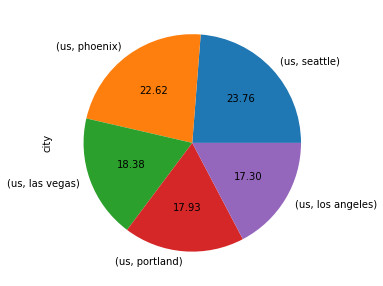

In [1]:
#libraries
import pandas as pd
import numpy as np
import io
import os
import json
import time
import dedupe
import datetime
import matplotlib.pyplot as plt
from causallift import CausalLift





#Read UFO info
def read_data():
    data = pd.read_csv('C:/Users/lsoledad/Documents/UFO/UFO_sightings.csv')
    path = os.listdir('C:/Users/lsoledad/Documents/UFO')
    print(path)
    return data,path
def clean_data(data,path):
    #########
    data=data[1:]
    #Drop exact duplicates ---80321 
    Column=data.keys().tolist()
    d= {'Column': ['' for x in range(len(data)+1)]}
    df2 = pd.DataFrame(d)
    for x in Column:
        df2['Column'] = df2['Column'].astype(str).replace(' ','', regex=True) + data[x].fillna(' ').astype(str).replace(' ', '', regex=True)
    
    df3 = df2['Column'][df2['Column'].duplicated(keep=False) == False][1:]
    df3 = data.loc[df3.index][Column]

    
    #Delete Na values in longitude,altitude, city and datetime columns.---66505
    df3=df3[Column].dropna()

    
    #Drop exact duplicates of datetime|state|country|longitude |latitude : they are the keys to know where the UFO can be---63686
    Columna=['datetime','state','country','longitude ','latitude']
    d= {'Column': ['' for x in range(len(df3)+1)]}
    df4 = pd.DataFrame(d)
    for x in Columna:
        df4['Column'] = df4['Column'].astype(str).replace(' ','', regex=True) + data[x].fillna(' ').astype(str).replace(' ', '', regex=True)
    
    df5 = df4['Column'][df4['Column'].duplicated(keep=False) == False][1:]
    df5 = data.loc[df5.index][Column]
    #Convert latitude and duration(seconds) to numeric and if one is not numeric, trucate it.---63683---63682
    df5=df5[pd.to_numeric(df5['duration (seconds)'], errors='coerce').notnull()]
    df5=df5[pd.to_numeric(df5['latitude'], errors='coerce').notnull()]
    
    df6=df5.loc[:, ['city']]


    #Comienzo del algoritmo Machine Learning Dedupe
    ##############################
    df6 = df6.replace(np.nan,'None')   ##IMPORTANTISIMO, SI NO SE CORRE ESTO MEJOR QUE NO SE CORRA NADA
    Column=['city']
    data_d = {}
    for x in range(len(df6)):
        data_temp = {}
        for column in Column:
            data_temp[column] = str(df6.iloc[x][column]).strip()          
        data_d[x] = data_temp

    flag = True
    settings_file = str(Column)
    
    if os.path.exists(settings_file):
        flag = False
        print('reading from', settings_file)
        with open(settings_file, 'rb') as f:
            deduper = dedupe.StaticDedupe(f)
        print('Lectura en deduper exitosa')
            
        try:
            reporte2 = clustering(data_d, df6, Column, deduper)
            return df5,reporte2
        except:
            print('Casi no hay datos duplicados')
            return df5
        
    if flag:
        print('Empezando entrenamiento del modelo')
        reporte2 = training_dedupe(data_d, df6, Column)
        return df5,reporte2

        return df5
            

#######################################

def clustering(data_d, df, columns, deduper):
    
    
    print('clustering...')
    clustered_dupes = deduper.partition(data_d, 0.6)  #aqui habia 0.6
    print('# duplicate sets', len(clustered_dupes))
    cluster_membership = {}
    for cluster_id, (records, scores) in enumerate(clustered_dupes):
        for record_id, score in zip(records, scores):
            cluster_membership[record_id] = {"Cluster ID": cluster_id,
                                             "confidence_score": score
                                            }
    
    result = pd.DataFrame.from_dict(cluster_membership).T.sort_index()
    r = pd.merge(df, result, left_index=True, right_index=True)
    r = r.sort_values(by=['Cluster ID'])
    ids = r['Cluster ID']
    r = r[ids.isin(ids[ids.duplicated()])]
    
    
    ############### para el reporte#############
    d = {'Valor': ['' for x in range(len(r))]}
    reporte2 = pd.DataFrame(d)
    for c in columns:
        reporte2['Valor'] = reporte2['Valor'].astype(str) + r[c].reset_index(drop=True).fillna(' ').astype(str) + '|'
        
    
    list_of_tuples = list(zip(reporte2['Valor'],
                              r['Cluster ID'])) 

    result=pd.DataFrame(list_of_tuples, columns=['city','cluster'])

    return result


def training_dedupe(data_d, df, columns):
    
    #print(data_d)
    settings_file = str(columns)
    fields = []
    for column in columns:
        fields.append({'field' : column, 'type': 'String', 'has missing' : True})
    
    print(fields)    
    # Create a new deduper object and pass our data model to it.
    deduper = dedupe.Dedupe(fields)

    deduper.prepare_training(data_d, blocked_proportion = 0.9)

    pair = deduper.uncertain_pairs()
    print(pair)
    print('starting active labeling...')

    dedupe.console_label(deduper)

    # Using the examples we just labeled, train the deduper and learn
    # blocking predicates
    deduper.train()

    # Save our weights and predicates to disk.  If the settings file
    # exists, we will skip all the training and learning next time we run
    # this file.
    option = input('Deseas subir el nuevo archivo de entrenamiento a tu bucket? y/n')
    if  'y' in option or 'Y' in option and 'n' not in option:
        with open(settings_file, 'wb') as sf:
            deduper.write_settings(sf)
        
        with open('learned_settings_city', "w") as f:
            deduper.write_training(f)
            print('Training file, loaded\n\n')
            
    return clustering(data_d, df, columns, deduper)


def analysis(df5,reporte2):
    print('This is a ML process that gives us the clusters for each city that can be similar into meaning or misspelled ')
    print(reporte2)
    state=df5['city'].groupby(df5['country']).value_counts().nlargest(5)
    print('Top 5 Count of the cities group by country')
    print(state)
    plt.figure()
    #state.plot.pie()
    plot = state.plot.pie(y='city', figsize=(5, 5),autopct='%.2f')
    print('The amount of times a UFO was seen by state and country')
    cross=pd.crosstab(df5['country'], df5['state'], margins = True)
    print(cross)
    print('Most likely cities in the hole data that a UFO can be seen next time')
    
#Main function
def main():
    data,path=read_data()
    df5,reporte2=clean_data(data,path)
    print('Analysis starts here:')
    analysis(df5,reporte2)
    print('Doing an analysis of data results, we can say that is more likely that the next ocurrence could be in US')
    print('Furthermore the main city is Seattle with latitude: 47.60621 longitude:-122.332071')
    
main()

    